In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2 as pg
import datetime
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import time
from sklearn.metrics import mean_squared_error
from matplotlib import dates as mdates
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.style.use("ggplot")

import utils.settings_utils as settings
import utils.DatasetAccess as db_access
import utils.preprocess as preprocess
import utils.prophet_experiment as exp

In [71]:
conn = pg.connect(database=settings.get_database(), user=settings.get_user(), password=settings.get_pasword())

In [72]:
time_limit='2000-01-01 00:00:00'
company_id = 15611
time_unit = 'H'
regressors = ['open', 'high', 'low', 'volume']


In [73]:
ds = db_access.get_data_for_datasetid(company_id, conn, time_unit, time=time_limit)
ds = preprocess.rename_dataset_columns(ds)
ds.head()

c:\Users\Stonker69\Documents\GitHub\BiksStonks\Forcasting_Models\stonkenv\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,ds,open,high,low,y,volume
0,2020-03-04 10:00:00,139.44,139.88,138.88,139.68,185079.997242
1,2020-03-04 11:00:00,139.60,139.92,139.20,139.68,152614.997726
2,2020-03-04 12:00:00,139.68,141.08,139.48,140.64,324759.995161
3,2020-03-04 13:00:00,140.64,140.68,139.56,140.12,360814.994623
4,2020-03-04 14:00:00,140.08,141.00,139.40,139.76,364974.994561


In [84]:
end_date = ds.iloc[-1]['ds']
start_date = ds.iloc[0]['ds']

start_date, end_date

(Timestamp('2020-03-04 10:00:00'), Timestamp('2022-03-04 09:00:00'))

In [75]:
split_date = (end_date - ((end_date - start_date) * 0.3))

In [76]:
training = ds[ds['ds'] <= split_date]
testing = ds[ds['ds'] > split_date]

predict_period = len(testing['ds'])
df = training.reset_index()

In [77]:
model = Prophet(mcmc_samples=300, seasonality_mode='multiplicative')

for regressor in regressors:
    model.add_regressor(regressor, prior_scale=0.5, mode='multiplicative')

In [78]:
model.fit(training)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [85]:
future = model.make_future_dataframe(periods=predict_period, freq=time_unit, include_history=False)
future.head(), future.tail(), len(future['ds'])

(                   ds
 0 2021-07-28 10:00:00
 1 2021-07-28 11:00:00
 2 2021-07-28 12:00:00
 3 2021-07-28 13:00:00
 4 2021-07-28 14:00:00,
                       ds
 1234 2021-09-17 20:00:00
 1235 2021-09-17 21:00:00
 1236 2021-09-17 22:00:00
 1237 2021-09-17 23:00:00
 1238 2021-09-18 00:00:00,
 1239)

In [86]:
for regressor in regressors:
    regressor_df = ds[['ds', regressor]].copy()
    future = future.merge(regressor_df, how='left', on='ds')
    future = future.dropna()

future.head()

,ds,open,high,low,volume
0,2021-07-28 10:00:00,232.1,232.3,230.6,69688.0
1,2021-07-28 11:00:00,231.0,232.0,230.3,80855.0
2,2021-07-28 12:00:00,230.2,231.2,229.1,78171.0
3,2021-07-28 13:00:00,231.1,232.0,230.3,120132.0
4,2021-07-28 14:00:00,232.1,233.4,231.2,253513.0


In [90]:
forecast=model.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,extra_regressors_multiplicative,...,volume,volume_lower,volume_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2021-07-28 10:00:00,211.872902,229.973927,231.918103,201.109302,222.276175,-0.036716,-0.082957,0.013029,0.128818,...,-0.000020,-0.000138,0.000093,-0.000350,-0.001202,0.000547,0.0,0.0,0.0,231.312666
1,2021-07-28 11:00:00,211.872893,230.227045,232.138487,201.109268,222.276185,-0.036702,-0.083111,0.012934,0.129757,...,-0.000019,-0.000131,0.000089,-0.000306,-0.001148,0.000589,0.0,0.0,0.0,231.523667
2,2021-07-28 12:00:00,211.872884,229.179464,231.069463,201.109234,222.276195,-0.036741,-0.083229,0.012874,0.124531,...,-0.000020,-0.000133,0.000090,-0.000261,-0.001097,0.000629,0.0,0.0,0.0,230.417943
3,2021-07-28 13:00:00,211.872876,230.212886,232.192598,201.109201,222.276205,-0.036677,-0.083031,0.013092,0.129466,...,-0.000016,-0.000109,0.000074,-0.000214,-0.001057,0.000675,0.0,0.0,0.0,231.486905
4,2021-07-28 14:00:00,211.872867,231.489175,233.323501,201.109167,222.276215,-0.036605,-0.083128,0.013168,0.135456,...,-0.000005,-0.000034,0.000023,-0.000165,-0.000996,0.000728,0.0,0.0,0.0,232.781706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,2021-09-17 10:00:00,211.862076,250.399423,253.579291,200.908899,222.373238,-0.036716,-0.082957,0.013029,0.228601,...,-0.000019,-0.000129,0.000087,-0.000300,-0.001204,0.000657,0.0,0.0,0.0,252.451575
297,2021-09-17 11:00:00,211.862067,249.513837,252.780579,200.911004,222.374987,-0.036702,-0.083111,0.012934,0.224130,...,-0.000019,-0.000131,0.000089,-0.000232,-0.001069,0.000661,0.0,0.0,0.0,251.521754
298,2021-09-17 12:00:00,211.862058,249.573838,252.779361,200.913109,222.376737,-0.036741,-0.083229,0.012874,0.224038,...,-0.000019,-0.000126,0.000085,-0.000157,-0.000914,0.000678,0.0,0.0,0.0,251.509859
299,2021-09-17 13:00:00,211.862049,248.089994,251.351342,200.914549,222.378486,-0.036677,-0.083031,0.013092,0.217141,...,-0.000011,-0.000071,0.000048,-0.000077,-0.000786,0.000704,0.0,0.0,0.0,250.079138


c:\Users\Stonker69\Documents\GitHub\BiksStonks\Forcasting_Models\stonkenv\lib\site-packages\fbprophet\plot.py:413: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
c:\Users\Stonker69\Documents\GitHub\BiksStonks\Forcasting_Models\stonkenv\lib\site-packages\fbprophet\plot.py:413: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
c:\Users\Stonker69\Documents\GitHub\BiksStonks\Forcasting_Models\stonkenv\lib\site-packages\fbprophet\plot.py:413: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)


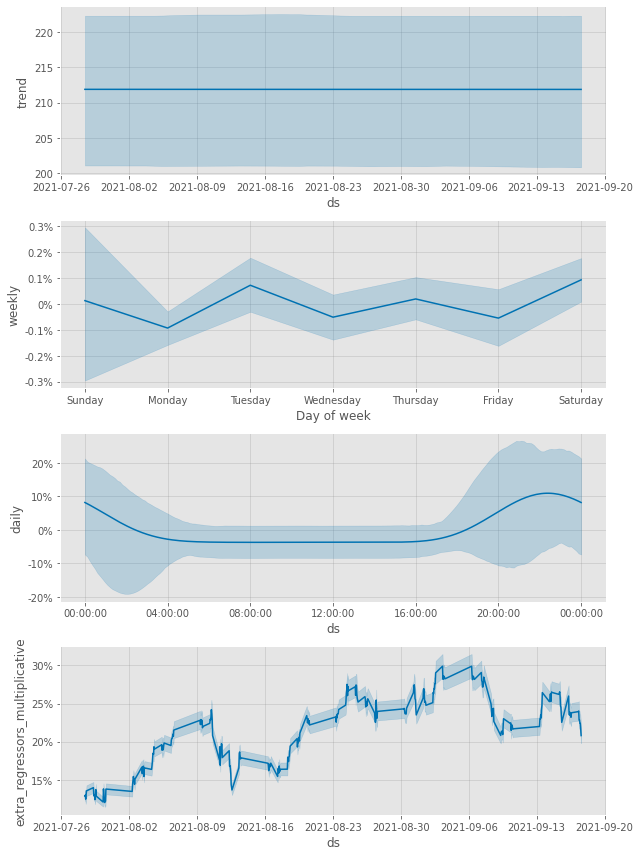

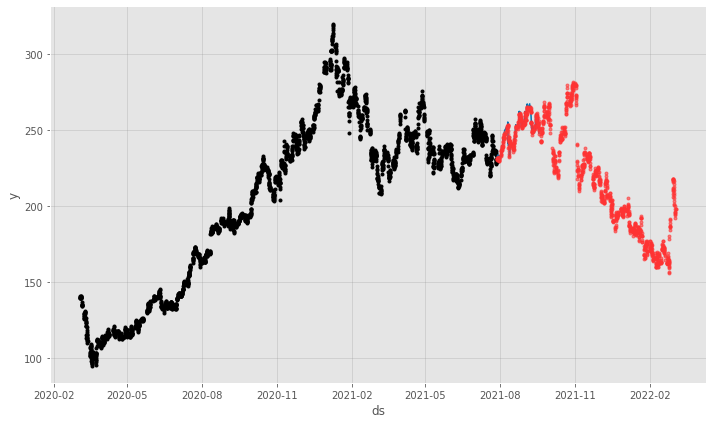

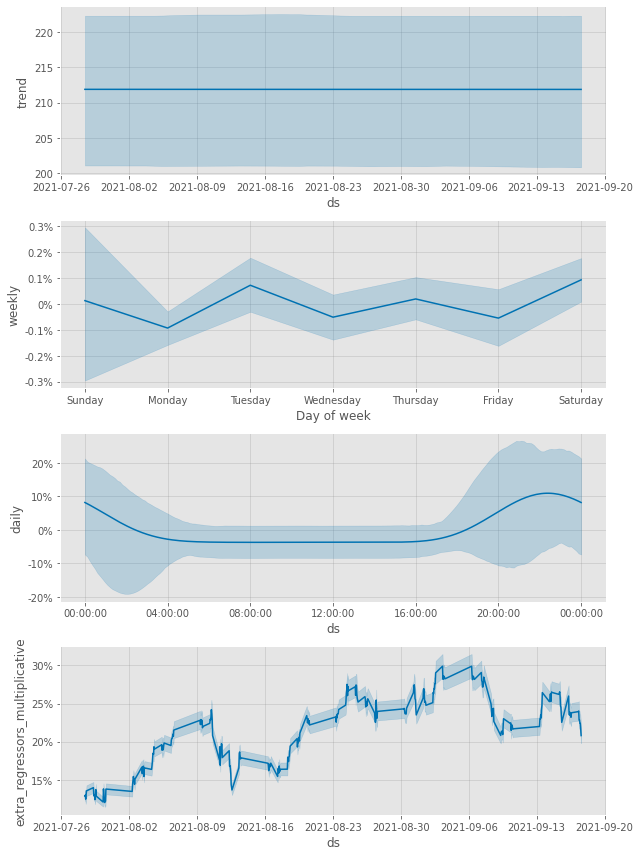

In [88]:
model.plot(forecast)
plt.plot(testing.ds, testing.y, '.', color='#ff3333', alpha=0.6)
model.plot_components(forecast)